# Purpose

This one demos output for `v0.3.2` that includes top subreddits (no Geo) AND German-relevant subreddits! Should be helpful to check for subreddit counterparts.

Use this notebook to present the outputs for the final output (or close to it). 

We need this notebook to show some clear examples on how to use the data and where/how we can use it.

# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [183]:
from datetime import datetime
import logging
from pprint import pprint

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns

import mlflow

import omegaconf
from omegaconf import OmegaConf
from subclu.utils.hydra_config_loader import LoadHydraConfig

import subclu
from subclu.data.data_loaders import LoadSubreddits, LoadPosts
from subclu.utils import set_working_directory
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.language_code_mapping import (
    L_CLD3_CODES_FOR_LANGUAGES_IN_USE_MULTILINGUAL, L_USE_MULTILINGUAL_LANGUAGES,
    D_CLD3_CODE_TO_LANGUAGE_NAME,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl
)

# ---
from tqdm.auto import tqdm

print_lib_versions([np, pd, plotly, sns, subclu])

python		v 3.7.10
===
numpy		v: 1.19.5
pandas		v: 1.2.4
plotly		v: 4.14.3
seaborn		v: 0.11.1
subclu		v: 0.3.2


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Set sqlite database as MLflow URI

In [4]:
# use new class to initialize mlflow
mlf = MlflowLogger(tracking_uri='sqlite')
mlflow.get_tracking_uri()

'sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db'

## Get list of experiments with new function

In [41]:
mlf.list_experiment_meta(output_format='pandas').tail(8)

,experiment_id,name,artifact_location,lifecycle_stage
5,5,use_multilingual_v0.1_test,gs://i18n-subreddit-clustering/mlflow/mlruns/5,active
6,6,use_multilingual_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/6,active
7,7,use_multilingual_v1_aggregates_test,gs://i18n-subreddit-clustering/mlflow/mlruns/7,active
8,8,use_multilingual_v1_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/8,active
9,9,v0.3.2_use_multi_inference_test,gs://i18n-subreddit-clustering/mlflow/mlruns/9,active
10,10,v0.3.2_use_multi_inference,gs://i18n-subreddit-clustering/mlflow/mlruns/10,active
11,11,v0.3.2_use_multi_aggregates_test,gs://i18n-subreddit-clustering/mlflow/mlruns/11,active
12,12,v0.3.2_use_multi_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/12,active


# Load config
Use Hydra configs to make it easier to replicate the run.

Copy the config to the model folder so it's easier to trace it back

In [8]:
mlflow_experiment_test = 'v0.3.2_use_multi_aggregates_test'
# mlflow_experiment_full = 'v0.3.2_use_multi_aggregates'

config_full_lc_false = LoadHydraConfig(
    config_name='clustering_adhoc',
    config_path="../config",
    overrides=[f"data_text_and_metadata=top_subreddits_2021_07_16",
               'data_embeddings_to_cluster=top_subs-2021_07_16-use_multi_lower_case_false_00',
              ]
)

# pprint(config_test_sample_lc_false.config_dict, indent=2)

In [15]:
pprint(config_full_lc_false.config_dict)

{'data_embeddings_to_cluster': {'df_post_level_agg_b_post_and_comments': 'df_post_level_agg_b_post_and_comments',
                                'df_post_level_agg_c_post_comments_sub_desc': 'df_post_level_agg_c_post_comments_sub_desc',
                                'df_sub_level_agg_a_post_only': 'df_sub_level_agg_a_post_only',
                                'df_sub_level_agg_a_post_only_similarity': 'df_sub_level_agg_a_post_only_similarity',
                                'df_sub_level_agg_a_post_only_similarity_pair': 'df_sub_level_agg_a_post_only_similarity_pair',
                                'df_sub_level_agg_b_post_and_comments': 'df_sub_level_agg_b_post_and_comments',
                                'df_sub_level_agg_b_post_and_comments_similarity': 'df_sub_level_agg_b_post_and_comments_similarity',
                                'df_sub_level_agg_b_post_and_comments_similarity_pair': 'df_sub_level_agg_b_post_and_comments_similarity_pair',
                              

In [21]:
d_embeddings = config_full_lc_false.config_dict['data_embeddings_to_cluster']
d_conf_meta = config_full_lc_false.config_dict['data_text_and_metadata']

run_uuid = d_embeddings['run_uuid']

f_embeddings_sub_level = d_embeddings['df_sub_level_agg_c_post_comments_and_sub_desc']
f_embeddings_post_level = d_embeddings['df_post_level_agg_c_post_comments_sub_desc']

f_sub_distance_c = d_embeddings['df_sub_level_agg_c_post_comments_and_sub_desc_similarity']
f_sub_dist_pair = d_embeddings['df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair']


l_ix_sub = d_embeddings['l_ix_sub']  # 'subreddit_id',  b/c of dask's multi-index, I'm only using nam
l_ix_post = d_embeddings['l_ix_post']

# List & load artifacts from selected run

This is a run-ID for a process that outputs post-level and subreddit artifacts (after aggregation).

In [19]:
%%time

d_dfs_mlflow = mlf.read_run_artifact(
    run_id=run_uuid,
    artifact_folder='d_logged_dfs_subfolders/d_logged_dfs_subfolders.json',
    read_function='json',
)

pprint(list(d_dfs_mlflow.keys()))

17:18:27 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/12/99158c385c5442b1bf5ff96fc44af7da/artifacts/d_logged_dfs_subfolders/d_logged_dfs_subfolders.json"


  0%|          | 0/1 [00:00<?, ?it/s]

17:18:27 | INFO | "  Parquet files found: 0"


['df_post_level_agg_b_post_and_comments',
 'df_post_level_agg_c_post_comments_sub_desc',
 'df_sub_level_agg_a_post_only',
 'df_sub_level_agg_a_post_only_similarity',
 'df_sub_level_agg_a_post_only_similarity_pair',
 'df_sub_level_agg_b_post_and_comments',
 'df_sub_level_agg_b_post_and_comments_similarity',
 'df_sub_level_agg_b_post_and_comments_similarity_pair',
 'df_sub_level_agg_c_post_comments_and_sub_desc',
 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity',
 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair']
CPU times: user 668 ms, sys: 7.51 ms, total: 676 ms
Wall time: 3.24 s


## Load distances

In [113]:
%%time

df_sub_d_pair = mlf.read_run_artifact(
    run_id=run_uuid,
    artifact_folder=f_sub_dist_pair,
    read_function='pd_parquet',
)
try:
    df_sub_d_pair = df_sub_d_pair.drop(['index'], axis=1)
except KeyError:
    pass

print(df_sub_d_pair.shape)

21:17:05 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/12/99158c385c5442b1bf5ff96fc44af7da/artifacts/df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair"


  0%|          | 0/36 [00:00<?, ?it/s]

21:17:05 | INFO | "  Parquet files found: 34"


(14186522, 3)
CPU times: user 4.11 s, sys: 1.09 s, total: 5.2 s
Wall time: 2.01 s


In [114]:
df_sub_d_pair.head()

,cosine_distance,subreddit_name_a,subreddit_name_b
0,0.719657,1071,tamamahbapengelli
1,0.708699,1071,nonakanal
2,0.706756,1071,okemakkermaloot
3,0.706363,1071,kudurdum
4,0.698231,1071,okbrudimongo


## Load post metadata - explore language labels

Now that we're moving beyond German, we want to know what's the predominant language in a subreddit

In [115]:
# print(len(L_CLD3_CODES_FOR_LANGUAGES_IN_USE_MULTILINGUAL))
# for code_ in L_CLD3_CODES_FOR_LANGUAGES_IN_USE_MULTILINGUAL:
#     print(f"{code_}: {D_CLD3_CODE_TO_LANGUAGE_NAME[code_]}")

In [28]:
pprint(d_conf_meta)

{'bucket_name': 'i18n-subreddit-clustering',
 'dataset_name': 'Top Subreddits (no Geo) + German Subs 2021-07-16, comments: '
                 '2021-07-09',
 'folder_comments_text_and_meta': 'comments/top/2021-07-09',
 'folder_posts_text_and_meta': 'posts/top/2021-07-16',
 'folder_subreddits_text_and_meta': 'subreddits/top/2021-07-16'}


In [121]:
%%time
l_cols_post_aggs_only = [
    'subreddit_name',
    'subreddit_id',
    'post_id',
    'weighted_language',    # For language aggs
    'post_type',            # For post aggs
    'combined_topic_and_rating',    # Needed for new manual label
    'text_word_count',      # To get median post word count
]

df_post_meta = LoadPosts(
    bucket_name=d_conf_meta['bucket_name'],
    folder_path=d_conf_meta['folder_posts_text_and_meta'],
    columns=l_cols_post_aggs_only,
).read_and_apply_transformations()

21:20:17 | INFO | "Reading raw data..."
21:20:17 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/posts/top/2021-07-16"


  0%|          | 0/43 [00:00<?, ?it/s]

21:20:19 | INFO | "  Applying transformations..."


CPU times: user 9.19 s, sys: 529 ms, total: 9.72 s
Wall time: 8.96 s


In [122]:
# df_post_meta.head()

In [125]:
value_counts_and_pcts(
    df_post_meta['weighted_language_top'],
    top_n=19,
)

,weighted_language_top-count,weighted_language_top-percent,weighted_language_top-pct_cumulative_sum
English,"1,370,419",83.1%,83.1%
other_language,"126,010",7.6%,90.7%
German,"75,712",4.6%,95.3%
Portuguese,"13,887",0.8%,96.1%
Spanish,"13,788",0.8%,97.0%
UNKNOWN,"9,172",0.6%,97.5%
French,"9,102",0.6%,98.1%
Dutch,"8,077",0.5%,98.6%
Italian,"7,798",0.5%,99.0%
Turkish,"5,168",0.3%,99.3%


In [126]:
value_counts_and_pcts(
    df_post_meta['weighted_language'],
    top_n=15,
)

,weighted_language-count,weighted_language-percent,weighted_language-pct_cumulative_sum
en,"1,370,419",83.1%,83.1%
de,"75,712",4.6%,87.6%
pt,"13,887",0.8%,88.5%
es,"13,788",0.8%,89.3%
UNKNOWN,"9,172",0.6%,89.9%
fr,"9,102",0.6%,90.4%
no,"8,836",0.5%,91.0%
af,"8,737",0.5%,91.5%
nl,"8,077",0.5%,92.0%
it,"7,798",0.5%,92.5%


## Load metadata

This run of pair distances didn't have the metadata attached... so let's attach it

In [102]:
%%time
df_sub_meta = LoadSubreddits(
    bucket_name=d_conf_meta['bucket_name'],
    folder_path=d_conf_meta['folder_subreddits_text_and_meta'],
    folder_posts=d_conf_meta['folder_posts_text_and_meta'],
    columns=None,
).read_apply_transformations_and_merge_post_aggs()

21:06:22 | INFO | "Loading df_posts from: posts/top/2021-07-16"
21:06:22 | INFO | "Reading raw data..."
21:06:22 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/posts/top/2021-07-16"


  0%|          | 0/43 [00:00<?, ?it/s]

21:06:24 | INFO | "  Applying transformations..."
21:06:31 | INFO | "  reading sub-level data & merging with aggregates..."
21:06:31 | INFO | "Reading raw data..."
21:06:31 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/subreddits/top/2021-07-16"


  0%|          | 0/1 [00:00<?, ?it/s]

21:06:31 | INFO | "  Applying transformations..."


CPU times: user 11 s, sys: 702 ms, total: 11.7 s
Wall time: 11.1 s


In [128]:
l_cols_inspect_meta = [
    'subreddit_name',
    'combined_topic_and_rating',
    'rating',
    'topic',
    'over_18',
    
    'subreddit_title',
    
    'predominant_post_language',
    'predominant_post_language_percent',

]
l_cols_language_percent = [c for c in df_sub_meta.columns if c.endswith('_posts_percent')]

# df_sub_meta[l_cols_inspect_meta + l_cols_language_percent].head()

In [129]:
# df_sub_meta[l_cols_inspect_meta + l_cols_language_percent].tail()

In [130]:
# df_sub_meta[[c for c in df_sub_meta.columns if c.endswith('_posts_percent')]].head()

In [131]:
# pprint(list(df_sub_meta.columns))

### Merge meta with distance
see `transform_distance_data_for_bq` for function

In [133]:
%%time

col_new_manual_topic = 'manual_topic_and_rating'

l_meta_basic = [
    'subreddit_name',
    'subreddit_id',
    col_new_manual_topic,
    'rating',
    'topic',
    'predominant_post_language',
    'predominant_post_language_percent',
    'post_median_word_count',
]
df_sub_d_pair = (
    df_sub_d_pair
    .merge(
        df_sub_meta[l_meta_basic].set_index('subreddit_name'),
        left_on=['subreddit_name_a'],
        right_index=True,
    )
    .merge(
        df_sub_meta[l_meta_basic].set_index('subreddit_name'),
        left_on=['subreddit_name_b'],
        right_index=True,
        suffixes=('_a', '_b')
    )
    .sort_values(by=['subreddit_name_a', 'cosine_distance'], ascending=[True, False])
)

CPU times: user 24.8 s, sys: 3.23 s, total: 28 s
Wall time: 28 s


In [151]:
df_sub_d_pair.head()

,cosine_distance,subreddit_name_a,subreddit_name_b,cluster_id_b,manual_topic_and_rating_b,manual_topic_and_rating_a,rating_a,topic_a,predominant_post_language_a,predominant_post_language_percent_a,post_median_word_count_a,rating_b,topic_b,predominant_post_language_b,predominant_post_language_percent_b,post_median_word_count_b,subreddit_id_a,subreddit_id_b
0,0.719657,1071,tamamahbapengelli,4,uncategorized,uncategorized,None,None,Turkish,0.845133,9.0,None,None,Turkish,0.677419,4.0,t5_4ppr4q,t5_pwwzi
1,0.708699,1071,nonakanal,11,uncategorized,uncategorized,None,None,Turkish,0.845133,9.0,None,None,German,0.712589,6.0,t5_4ppr4q,t5_2ltn31
2,0.706756,1071,okemakkermaloot,74,uncategorized,uncategorized,None,None,Turkish,0.845133,9.0,None,None,other_language,0.467949,3.0,t5_4ppr4q,t5_pa6tc
3,0.706363,1071,kudurdum,14,uncategorized,uncategorized,None,None,Turkish,0.845133,9.0,None,None,Turkish,0.544170,7.0,t5_4ppr4q,t5_2pn1vr
4,0.698231,1071,okbrudimongo,74,internet culture and memes,uncategorized,None,None,Turkish,0.845133,9.0,r,Internet Culture and Memes,German,0.651042,4.0,t5_4ppr4q,t5_ofkj1


# Load clusters

Currently ad-hoc

In [152]:
path_clusters_mod = 'manual_2021-08-11_04_45'
bucket_clusters = f'gs://i18n-subreddit-clustering/data/models/clustering/{path_clusters_mod}'

f_subs_meta_and_svd = 'df_subs_meta_and_svd-3767_by_88.parquet'
f_subs_cluster_labels = 'df_subs_only-multiple_clustering_algos-3767_by_56.parquet'

col_clustering = 'cluster_id_agg_ward_cosine_200'

In [138]:
!gsutil ls -r $bucket_clusters

gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45/:
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45/df_posts_meta_and_svd-1651709_by_72.parquet
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45/df_subs_meta_and_svd-3767_by_88.parquet
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45/df_subs_only-multiple_clustering_algos-3767_by_56.parquet
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45/df_svd_posts_and_subs-1655476_by_50.parquet
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45/hydra_config.yaml


In [153]:
%%time
df_subs_meta_plot = pd.read_parquet(f"{bucket_clusters}/{f_subs_cluster_labels}")

df_subs_meta_plot.shape

CPU times: user 133 ms, sys: 50.3 ms, total: 183 ms
Wall time: 1.06 s


(3767, 56)

## Add new columns for predominant language so we can display them

In [170]:
df_subs_meta_plot = df_subs_meta_plot.merge(
    df_sub_meta[['subreddit_name', 'predominant_post_language', 'predominant_post_language_percent']],
    how='left',
    on=['subreddit_name']
)

In [155]:
# df_subs_meta_plot.head()

In [142]:
# counts_describe(df_subs_meta_plot)

## Append subreddit label to pair-wise df

Use it to show when a sub was found to be related or not to a related sub.

In [146]:
col_cluster_id_b = 'cluster_id_b'
df_sub_d_pair = (
    df_sub_d_pair.merge(
        df_subs_meta_plot[['subreddit_name', col_clustering]].rename(columns={'subreddit_name': 'subreddit_name_b'}),
        how='left',
        on=['subreddit_name_b'],
    )
    .rename(columns={col_clustering: col_cluster_id_b})
)



In [147]:
# reorder columns so it's easier to see topic
l_cols_sub_ids = ['subreddit_id_a', 'subreddit_id_b']

df_sub_d_pair = df_sub_d_pair[(
    reorder_array(
        ['cosine_distance', 'subreddit_name_a', 'subreddit_name_b', col_cluster_id_b,
         'manual_topic_and_rating_b', 'German_posts_percent_b', ],
        list(df_sub_d_pair.drop(l_cols_sub_ids, axis=1).columns) + l_cols_sub_ids,
    )
)]

21:31:26 | WARNING | "Values missing 1:
{'German_posts_percent_b'}"


In [150]:
# list(df_sub_d_pair.drop(l_cols_sub_ids, axis=1).columns)

In [156]:
df_sub_d_pair.head()

,cosine_distance,subreddit_name_a,subreddit_name_b,cluster_id_b,manual_topic_and_rating_b,manual_topic_and_rating_a,rating_a,topic_a,predominant_post_language_a,predominant_post_language_percent_a,post_median_word_count_a,rating_b,topic_b,predominant_post_language_b,predominant_post_language_percent_b,post_median_word_count_b,subreddit_id_a,subreddit_id_b
0,0.719657,1071,tamamahbapengelli,4,uncategorized,uncategorized,None,None,Turkish,0.845133,9.0,None,None,Turkish,0.677419,4.0,t5_4ppr4q,t5_pwwzi
1,0.708699,1071,nonakanal,11,uncategorized,uncategorized,None,None,Turkish,0.845133,9.0,None,None,German,0.712589,6.0,t5_4ppr4q,t5_2ltn31
2,0.706756,1071,okemakkermaloot,74,uncategorized,uncategorized,None,None,Turkish,0.845133,9.0,None,None,other_language,0.467949,3.0,t5_4ppr4q,t5_pa6tc
3,0.706363,1071,kudurdum,14,uncategorized,uncategorized,None,None,Turkish,0.845133,9.0,None,None,Turkish,0.544170,7.0,t5_4ppr4q,t5_2pn1vr
4,0.698231,1071,okbrudimongo,74,internet culture and memes,uncategorized,None,None,Turkish,0.845133,9.0,r,Internet Culture and Memes,German,0.651042,4.0,t5_4ppr4q,t5_ofkj1


# Define functions & cols to display

In [19]:
# [c for c in df_subs_meta_plot.columns if 'cluster_id' in c]

In [171]:
col_manual_labels = 'manual_topic_and_rating'
cols_to_front = [
    'subreddit_name',
    
    'manual_topic_and_rating',
    
    'subreddit_title',
#     'subreddit_public_description',
    
]
cols_to_exclude = [
    'subreddit_description',
    'subreddit_name_title_and_clean_descriptions',
    
    # cluster info not needed for now
    'cluster_id_kmeans20_all',
    'cluster_id_agg_ward_25',
    'cluster_id_agg_ward_35',
#     'cluster_id_agg_ward_cosine_35',
    'cluster_id_agg_avg_cosine_35',
    'cluster_id_agg_complete_cosine_35',
    'cluster_id_kmeans8',
    'cluster_id_kmeans15',
    'cluster_id_kmeans20',
    'cluster_id_hdbscan_cosine',
    'cluster_id_hdbscan_euclidean',
    'cluster_id_hdbscan_cosine_soft'

]

In [172]:
# cols_to_display = reorder_array(
#     cols_to_front,
#     df_subs_meta_plot.drop(cols_to_exclude, axis=1).columns
# )

cols_to_display = cols_to_front + [
#     'subreddit_name_title_and_clean_descriptions_word_count',
    
    'users_l28',
    'posts_l28',
    'comments_l28',
    
    'post_median_word_count',
    
    # Use predominant language instead of specific language col
    'predominant_post_language',
    'predominant_post_language_percent',
#     'English_posts_percent',
#     'other_language_posts_percent',
    
    'image_post_type_percent',
    'text_post_type_percent',
#     'link_post_type_percent',
#     'other_post_type_percent',
    
    'rating',
    'topic',
    'rating_version',
    'over_18',

]
# cols_to_display

In [173]:
# pd.set_option('display.max_colwidth', 180)
# pd.set_option('display.width', 200)

In [185]:
def display_items_for_cluster_id(
    df_subs_meta_plot,
    id_,
    cols_to_display=cols_to_display,
    col_manual_labels=col_manual_labels,
    n_subs_to_show: int = 15,
    set_subreddit_title_width: int = None,
) -> None:
    """
    """
    mask_ = df_subs_meta_plot[col_clustering] == id_
    print(f"\nCluster ID: {id_}\n  {mask_.sum()} Subreddit count in group")
    

    display(
        value_counts_and_pcts(
            df_subs_meta_plot[mask_][col_manual_labels],
            add_col_prefix=False,
            reset_index=True,
            cumsum=False,
        ).hide_index()
    )
    if set_subreddit_title_width is not None:
        display(
            style_df_numeric(
                df_subs_meta_plot[mask_][cols_to_display]
                .sort_values(by=['users_l28'], ascending=False)
                .head(n_subs_to_show)
                ,
                rename_cols_for_display=True,
                l_bar_simple=[
                    'German_posts_percent', 'English_posts_percent',
                    'image_post_type_percent', 'text_post_type_percent',
                    'users_l28',
                ]
            ).set_properties(subset=['subreddit title'], **{'width': f'{set_subreddit_title_width}px'}).hide_index()
        )
    else:
        display(
            style_df_numeric(
                df_subs_meta_plot[mask_][cols_to_display]
                .sort_values(by=['users_l28'], ascending=False)
                .head(n_subs_to_show)
                ,
                rename_cols_for_display=True,
                l_bar_simple=[
                    'German_posts_percent', 'English_posts_percent',
                    'image_post_type_percent', 'text_post_type_percent',
                    'users_l28',
                ]
            )
        )

# Plot all subs

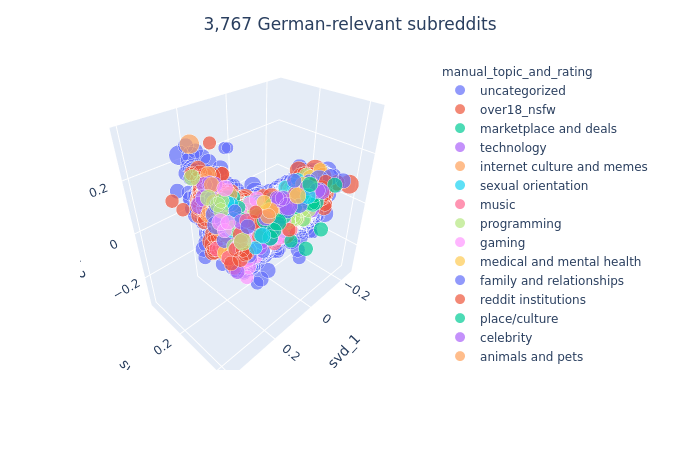

CPU times: user 340 ms, sys: 0 ns, total: 340 ms
Wall time: 2.9 s


In [175]:
%%time

df_plot_ = (
    df_subs_meta_plot  #[df_subs_meta_plot['subreddit_name'].isin(set_subs_all_similar)]
)

l_custom_data_subs = [
  'subreddit_name', 
  col_manual_labels,
  # 'text_1',
  # 'text_2',
]
sub_hover_data = "<br>".join([
    "subreddit name: %{customdata[0]}",
    "subreddit manual label: %{customdata[1]}",
    # "post text: %{customdata[2]}",
    # "  %{customdata[3]}"
])

fig = px.scatter_3d(
    df_plot_,
    y='svd_0', x='svd_1', z='svd_2',
    color=col_manual_labels,  # color=col_manual_labels,
    custom_data=l_custom_data_subs,
    size=np.log2(1 + df_plot_['users_l28']),
#     text='subreddit_name',
    # hoverinfo='text',
)

fig.update_traces(hovertemplate=sub_hover_data)
fig.update_layout(
    title_text=(
        # f"Most similar subreddits to <i>r/{sub_}</i>"
        f"{len(df_subs_meta_plot):,.0f} German-relevant subreddits"
        # f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
        # f"<br>Using posts from 04-01-2021 to 05-08-2021"
    ),
    title_x=0.5,
    width=800,
    height=600,
#     uniformtext_minsize=8, uniformtext_mode='hide'
)
fig.show(renderer='png')
# fig.show()

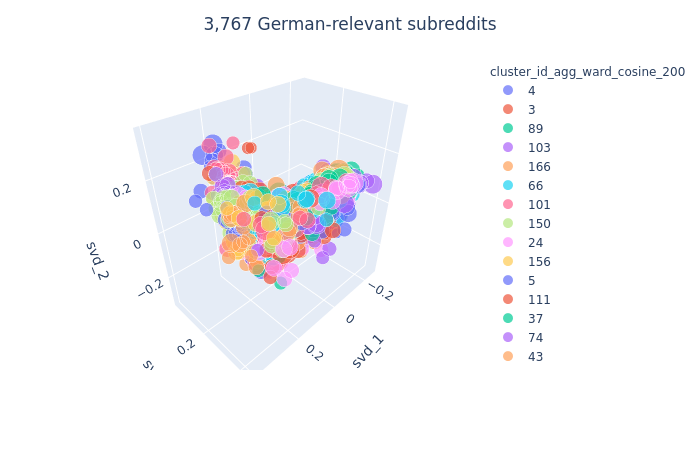

CPU times: user 1.12 s, sys: 7.47 ms, total: 1.12 s
Wall time: 5.18 s


In [176]:
%%time

df_plot_ = (
    df_subs_meta_plot  #[df_subs_meta_plot['subreddit_name'].isin(set_subs_all_similar)]
)

l_custom_data_subs = [
  'subreddit_name', 
  col_manual_labels,
  # 'text_1',
  # 'text_2',
]
sub_hover_data = "<br>".join([
    "subreddit name: %{customdata[0]}",
    "subreddit manual label: %{customdata[1]}",
    # "post text: %{customdata[2]}",
    # "  %{customdata[3]}"
])

fig = px.scatter_3d(
    df_plot_,
    y='svd_0', x='svd_1', z='svd_2',
    color=col_clustering,  # color=col_manual_labels,
    custom_data=l_custom_data_subs,
    size=np.log2(1 + df_plot_['users_l28']),
#     text='subreddit_name',
    # hoverinfo='text',
)

fig.update_traces(hovertemplate=sub_hover_data)
fig.update_layout(
    title_text=(
        # f"Most similar subreddits to <i>r/{sub_}</i>"
        f"{len(df_subs_meta_plot):,.0f} German-relevant subreddits"
        # f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
        # f"<br>Using posts from 04-01-2021 to 05-08-2021"
    ),
    title_x=0.5,
    width=800,
    height=600,
#     uniformtext_minsize=8, uniformtext_mode='hide'
)
fig.show(renderer='png')
# fig.show()

# Context - why does this work matter?
Of the 628 most active German subreddits, almost half of the top German subs are unlabeled (`uncategorized`) and 

In [164]:
value_counts_and_pcts(
    df_subs_meta_plot[col_manual_labels],
    add_col_prefix=False,
    reset_index=True,
    top_n=20,
)

,manual_topic_and_rating,count,percent,cumulative_percent
0,uncategorized,"2,935",77.9%,77.9%
1,over18_nsfw,359,9.5%,87.4%
2,gaming,46,1.2%,88.7%
3,internet culture and memes,40,1.1%,89.7%
4,place/culture,29,0.8%,90.5%
5,technology,29,0.8%,91.3%
6,music,21,0.6%,91.8%
7,crypto,19,0.5%,92.3%
8,animals and pets,17,0.5%,92.8%
9,podcasts and streamers,15,0.4%,93.2%


# Examples

For a given subreddit, show:
- closest subreddits (pair)
- cluster assigned by Machine Learning model

In [179]:
[c for c in df_sub_meta['subreddit_name'] if 'finan' in c]

['personalfinance', 'povertyfinance', 'finanzen', 'finance', 'ethfinance', 'financial']

,cosine distance,subreddit name a,subreddit name b,cluster id b,manual topic and rating b,manual topic and rating a,rating a,topic a,predominant post language a,predominant post language percent a,post median word count a,rating b,topic b,predominant post language b,predominant post language percent b,post median word count b
0,0.6229,futbol,football,81,uncategorized,uncategorized,None,None,Turkish,83.83%,19,pg13,None,English,74.25%,14
1,0.5692,futbol,soccer,81,uncategorized,uncategorized,None,None,Turkish,83.83%,19,pg13,None,English,87.50%,18
2,0.5675,futbol,fussball,81,uncategorized,uncategorized,None,None,Turkish,83.83%,19,None,None,German,62.40%,14
3,0.5656,futbol,bundesliga,81,sports,uncategorized,None,None,Turkish,83.83%,19,pg13,Sports,English,61.15%,12
4,0.5602,futbol,schalke04,81,uncategorized,uncategorized,None,None,Turkish,83.83%,19,pg,None,English,72.82%,12
5,0.5489,futbol,svw,81,uncategorized,uncategorized,None,None,Turkish,83.83%,19,None,None,English,78.26%,17
6,0.5434,futbol,elf,13,uncategorized,uncategorized,None,None,Turkish,83.83%,19,None,None,English,95.86%,21
7,0.5380,futbol,effzeh,81,uncategorized,uncategorized,None,None,Turkish,83.83%,19,pg,None,English,93.65%,14
8,0.5348,futbol,borussiadortmund,81,uncategorized,uncategorized,None,None,Turkish,83.83%,19,pg13,None,English,89.76%,16
9,0.5307,futbol,fiorentina,81,sports,uncategorized,None,None,Turkish,83.83%,19,pg,Sports,English,84.51%,18



Cluster ID: 81
  21 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,17,81.0%
sports,4,19.0%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
1813,soccer,uncategorized,The back page of the internet,"3,689,781","16,443","1,817,884",18,English,87.50%,2.75%,4.00%,pg13,None,v2,f
738,football,uncategorized,Football - The People's Sport,"372,114","2,332","18,850",14,English,74.25%,1.25%,42.17%,pg13,None,v2,f
2171,worldcup,uncategorized,World Cup,"49,226",148,"1,071",22,English,96.00%,4.57%,37.14%,pg,None,v1,f
3506,bundesliga,sports,German Bundesliga: News & Highlights,"27,771",122,"1,537",12,English,61.15%,0.72%,31.65%,pg13,Sports,v1,None
2799,borussiadortmund,uncategorized,Borussia Dortmund,"27,412",152,"4,064",16,English,89.76%,16.59%,40.00%,pg13,None,v2,f
3710,championsleague,sports,UEFA Champions League,"8,972",40,109,10,English,96.00%,12.00%,20.00%,pg,Sports,v3,f
2382,euro,uncategorized,Strictly Euro news,"8,883",96,89,8,English,80.91%,12.73%,22.73%,None,None,None,f
777,futbol,uncategorized,Todo sobre el fútbol mundial,"6,656","1,047",79,19,Turkish,83.83%,2.25%,3.17%,None,None,None,f
776,fussball,uncategorized,/r/fussball - Das deutschsprachige subreddit rund ums Thema Fußball,"4,180",272,527,14,German,62.40%,1.02%,42.71%,None,None,None,None
3600,schalke04,uncategorized,FC Schalke 04,"3,238",66,433,12,English,72.82%,5.83%,32.04%,pg,None,v1,None


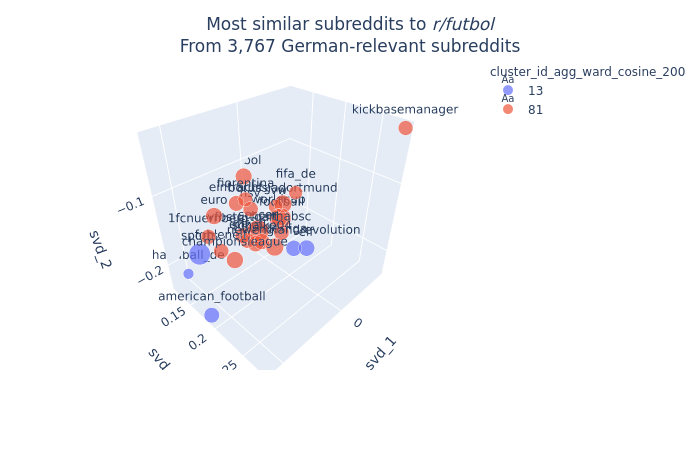

,cosine distance,subreddit name a,subreddit name b,cluster id b,manual topic and rating b,manual topic and rating a,rating a,topic a,predominant post language a,predominant post language percent a,post median word count a,rating b,topic b,predominant post language b,predominant post language percent b,post median word count b
0,0.8761,bundesliga,fussball,81,uncategorized,sports,pg13,Sports,English,61.15%,12,None,None,German,62.40%,14
1,0.8750,bundesliga,fohlenelf,81,uncategorized,sports,pg13,Sports,English,61.15%,12,pg13,None,English,91.30%,10
2,0.8664,bundesliga,borussiadortmund,81,uncategorized,sports,pg13,Sports,English,61.15%,12,pg13,None,English,89.76%,16
3,0.8618,bundesliga,schalke04,81,uncategorized,sports,pg13,Sports,English,61.15%,12,pg,None,English,72.82%,12
4,0.8386,bundesliga,vfbstuttgart,81,uncategorized,sports,pg13,Sports,English,61.15%,12,pg,None,English,86.54%,12
5,0.8338,bundesliga,soccer,81,uncategorized,sports,pg13,Sports,English,61.15%,12,pg13,None,English,87.50%,18
6,0.8288,bundesliga,effzeh,81,uncategorized,sports,pg13,Sports,English,61.15%,12,pg,None,English,93.65%,14
7,0.8215,bundesliga,elf,13,uncategorized,sports,pg13,Sports,English,61.15%,12,None,None,English,95.86%,21
8,0.8147,bundesliga,eintracht,81,uncategorized,sports,pg13,Sports,English,61.15%,12,pg,None,English,62.50%,9
9,0.8107,bundesliga,svw,81,uncategorized,sports,pg13,Sports,English,61.15%,12,None,None,English,78.26%,17



Cluster ID: 81
  21 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,17,81.0%
sports,4,19.0%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
1813,soccer,uncategorized,The back page of the internet,"3,689,781","16,443","1,817,884",18,English,87.50%,2.75%,4.00%,pg13,None,v2,f
738,football,uncategorized,Football - The People's Sport,"372,114","2,332","18,850",14,English,74.25%,1.25%,42.17%,pg13,None,v2,f
2171,worldcup,uncategorized,World Cup,"49,226",148,"1,071",22,English,96.00%,4.57%,37.14%,pg,None,v1,f
3506,bundesliga,sports,German Bundesliga: News & Highlights,"27,771",122,"1,537",12,English,61.15%,0.72%,31.65%,pg13,Sports,v1,None
2799,borussiadortmund,uncategorized,Borussia Dortmund,"27,412",152,"4,064",16,English,89.76%,16.59%,40.00%,pg13,None,v2,f
3710,championsleague,sports,UEFA Champions League,"8,972",40,109,10,English,96.00%,12.00%,20.00%,pg,Sports,v3,f
2382,euro,uncategorized,Strictly Euro news,"8,883",96,89,8,English,80.91%,12.73%,22.73%,None,None,None,f
777,futbol,uncategorized,Todo sobre el fútbol mundial,"6,656","1,047",79,19,Turkish,83.83%,2.25%,3.17%,None,None,None,f
776,fussball,uncategorized,/r/fussball - Das deutschsprachige subreddit rund ums Thema Fußball,"4,180",272,527,14,German,62.40%,1.02%,42.71%,None,None,None,None
3600,schalke04,uncategorized,FC Schalke 04,"3,238",66,433,12,English,72.82%,5.83%,32.04%,pg,None,v1,None


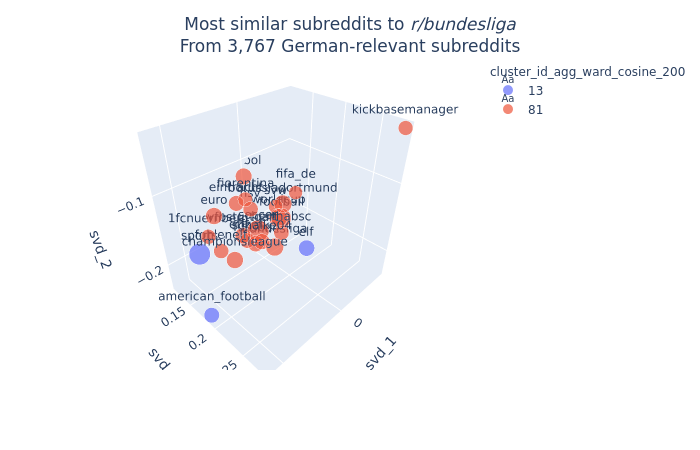

,cosine distance,subreddit name a,subreddit name b,cluster id b,manual topic and rating b,manual topic and rating a,rating a,topic a,predominant post language a,predominant post language percent a,post median word count a,rating b,topic b,predominant post language b,predominant post language percent b,post median word count b
0,0.8320,finanzen,investing,22,uncategorized,"business, economics, and finance",pg,"Business, Economics, and Finance",German,96.00%,103,pg13,None,English,99.50%,140
1,0.8306,finanzen,aktien,22,uncategorized,"business, economics, and finance",pg,"Business, Economics, and Finance",German,96.00%,103,None,None,German,96.74%,38
2,0.8240,finanzen,investingforbeginners,22,"business, economics, and finance","business, economics, and finance",pg,"Business, Economics, and Finance",German,96.00%,103,pg,"Business, Economics, and Finance",English,99.23%,67
3,0.8142,finanzen,personalfinance,34,uncategorized,"business, economics, and finance",pg,"Business, Economics, and Finance",German,96.00%,103,r,None,English,100.00%,165
4,0.8016,finanzen,portfolios,22,uncategorized,"business, economics, and finance",pg,"Business, Economics, and Finance",German,96.00%,103,pg13,None,English,97.74%,87
5,0.7977,finanzen,whitecoatinvestor,34,uncategorized,"business, economics, and finance",pg,"Business, Economics, and Finance",German,96.00%,103,pg13,None,English,99.38%,118
6,0.7872,finanzen,dividends,22,uncategorized,"business, economics, and finance",pg,"Business, Economics, and Finance",German,96.00%,103,pg13,None,English,99.69%,75
7,0.7770,finanzen,stocks,22,uncategorized,"business, economics, and finance",pg,"Business, Economics, and Finance",German,96.00%,103,not_shown_in_theaters,None,English,100.00%,117
8,0.7512,finanzen,options,22,uncategorized,"business, economics, and finance",pg,"Business, Economics, and Finance",German,96.00%,103,pg13,None,English,100.00%,94
9,0.7423,finanzen,investment,22,"business, economics, and finance","business, economics, and finance",pg,"Business, Economics, and Finance",German,96.00%,103,pg13,"Business, Economics, and Finance",English,95.74%,31



Cluster ID: 22
  28 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,22,78.6%
"business, economics, and finance",4,14.3%
internet culture and memes,1,3.6%
over18_nsfw,1,3.6%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
2111,wallstreetbets,uncategorized,wallstreetbets,"7,636,762","43,615","1,187,212",14,English,90.83%,35.67%,28.25%,r,None,v2,f
77,amcstock,uncategorized,amcstock,"1,864,135","46,778","980,536",12,English,88.67%,65.42%,20.33%,None,None,None,f
1862,stocks,uncategorized,Stocks - Investing and trading for all,"1,842,886","5,356","99,648",117,English,100.00%,0.00%,99.92%,not_shown_in_theaters,None,v2,f
998,investing,uncategorized,Lose money with friends!,"1,284,784","3,641","55,567",140,English,99.50%,0.00%,100.00%,pg13,None,v1,f
1498,pennystocks,uncategorized,Welcome to /r/pennystocks,"689,835","3,388","41,325",191,English,98.67%,11.67%,73.17%,r,None,v1,f
1458,options,uncategorized,/r/Options,"593,598","2,453","33,751",94,English,100.00%,0.75%,92.67%,pg13,None,v2,f
713,finanzen,"business, economics, and finance",Fragen und Antworten zu Finanzen,"233,475","1,096","29,755",103,German,96.00%,5.25%,82.00%,pg,"Business, Economics, and Finance",v1,None
556,dividends,uncategorized,Dividend Investing,"164,369",746,"15,064",75,English,99.69%,1.97%,92.86%,pg13,None,v2,f
1224,mauerstrassenwetten,internet culture and memes,mauerstrassenwetten,"133,744",653,"56,007",9,German,87.96%,53.98%,19.82%,r,Internet Culture and Memes,None,None
62,aktien,uncategorized,"Aktien, Handel und Investmentstrategien","22,071",306,"2,023",38,German,96.74%,5.87%,84.57%,None,None,None,f


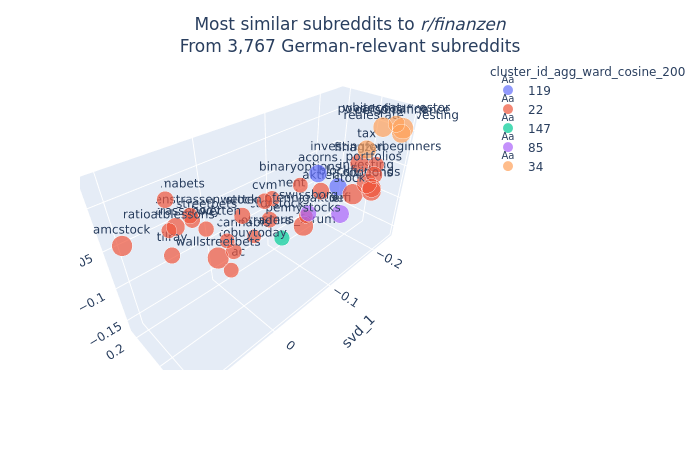

,cosine distance,subreddit name a,subreddit name b,cluster id b,manual topic and rating b,manual topic and rating a,rating a,topic a,predominant post language a,predominant post language percent a,post median word count a,rating b,topic b,predominant post language b,predominant post language percent b,post median word count b
0,0.8227,finance,fintech,147,uncategorized,uncategorized,pg13,None,English,95.32%,12,pg,None,English,92.64%,35
1,0.7988,finance,economy,147,uncategorized,uncategorized,pg13,None,English,95.32%,12,pg13,None,English,98.17%,12
2,0.7668,finance,businessnews,82,uncategorized,uncategorized,pg13,None,English,95.32%,12,pg13,None,English,91.07%,10
3,0.7665,finance,techcrunch,82,uncategorized,uncategorized,pg13,None,English,95.32%,12,g,None,English,98.67%,12
4,0.7431,finance,businesstalkdaily,82,uncategorized,uncategorized,pg13,None,English,95.32%,12,None,None,English,97.42%,11
5,0.7219,finance,cryptoeconomynet,85,crypto,uncategorized,pg13,None,English,95.32%,12,pg13,Crypto,English,97.45%,11
6,0.7205,finance,stockstobuytoday,22,uncategorized,uncategorized,pg13,None,English,95.32%,12,None,None,English,94.52%,16
7,0.7183,finance,doctorstock,22,uncategorized,uncategorized,pg13,None,English,95.32%,12,None,None,English,98.19%,52
8,0.7084,finance,econmonitor,147,uncategorized,uncategorized,pg13,None,English,95.32%,12,pg13,None,English,96.77%,9
9,0.6941,finance,business,118,uncategorized,uncategorized,pg13,None,English,95.32%,12,r,None,English,96.58%,14



Cluster ID: 147
  10 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,8,80.0%
"business, economics, and finance",1,10.0%
politics,1,10.0%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
601,economy,uncategorized,Economy,"220,981","1,534","21,631",12,English,98.17%,2.75%,5.75%,pg13,None,v2,f
2390,finance,uncategorized,Financial news and views,"185,844",875,"5,003",12,English,95.32%,2.74%,0.00%,pg13,None,v2,f
2583,oil,uncategorized,"Oil, gas, and other products that keep the world flowing","13,806",113,668,12,English,93.81%,11.50%,24.78%,pg13,None,v2,f
715,fintech,uncategorized,Fintech: financial technology,"12,254",262,234,35,English,92.64%,1.19%,41.33%,pg,None,v1,f
599,econmonitor,uncategorized,EconMonitor,"11,035",237,300,9,English,96.77%,0.00%,2.83%,pg13,None,v1,f
524,debitismus_forum,uncategorized,Wirtschaft und Gesellschaft ist Debitismus,"3,735",271,566,48,German,87.71%,0.00%,96.87%,None,None,None,f
2884,greed,politics,The Politics of Business,"1,506",44,48,13,English,97.06%,1.47%,13.24%,pg,Politics,v3,f
3370,marginal,uncategorized,Marginal Revolution,693,137,8,270,English,100.00%,0.00%,99.52%,pg,None,v1,f
3104,financial,"business, economics, and finance","Financial Questions, Discussions and News",658,218,9,80,English,99.12%,0.00%,99.71%,pg13,"Business, Economics, and Finance",v3,f
2073,vanhousing,uncategorized,Vancouver Housing Crisis,580,477,12,23,English,98.30%,0.14%,0.28%,None,None,None,f


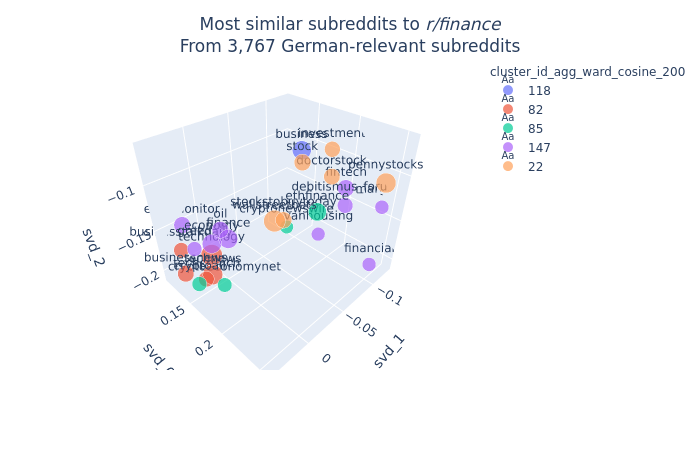

CPU times: user 3.53 s, sys: 46.3 ms, total: 3.58 s
Wall time: 10.1 s


In [186]:
%%time

for sub_ in ['futbol', 'bundesliga', 'finanzen', 'finance']:
    # closest subs
    df_closest_subs_ = (
        df_sub_d_pair[df_sub_d_pair['subreddit_name_a'] == sub_]
        .drop(['subreddit_id_a', 'subreddit_id_b'], axis=1)
        .reset_index(drop=True)
        .head(20)
    )
    l_closest_subs = [sub_] + list(df_closest_subs_['subreddit_name_b'])

    display(
        style_df_numeric(
            df_closest_subs_,
            rename_cols_for_display=True,
            l_bar_simple=['cosine_distance', 'German_posts_percent_b'],
            float_round=4,
        )  #.hide_index()
    )

    # cluster assigned by ML
    sub_id = df_subs_meta_plot.loc[df_subs_meta_plot['subreddit_name'] == sub_,
                                   col_clustering].values[0]
    l_subs_in_cluster = list(
        df_subs_meta_plot[df_subs_meta_plot[col_clustering] == sub_id]
        ['subreddit_name']
    )

    display_items_for_cluster_id(
        df_subs_meta_plot=df_subs_meta_plot,
        id_=sub_id,
    )

    set_subs_all_similar = set(l_closest_subs) | set(l_subs_in_cluster)
    # print(set_subs_all_similar)


    # display overlap between closest subs and subs that are part of the selected cluster
    # options:
    #  - Could display in SVD or t-sne space as dots
    #  - Could display as a table with flags for cluster IDs & distances
    #. - or venn diagram?
    # works with recent plotly (custom data)
    df_plot_ = (
        df_subs_meta_plot[df_subs_meta_plot['subreddit_name'].isin(set_subs_all_similar)]
    )

    l_custom_data_subs = [
      'subreddit_name', 
      col_manual_labels,
      # 'text_1',
      # 'text_2',
    ]
    sub_hover_data = "<br>".join([
        "subreddit name: %{customdata[0]}",
        "subreddit manual label: %{customdata[1]}",
        # "post text: %{customdata[2]}",
        # "  %{customdata[3]}"
    ])

    fig = px.scatter_3d(
        df_plot_,
        y='svd_0', x='svd_1', z='svd_2',
        color=col_clustering,  # color=col_manual_labels,
        custom_data=l_custom_data_subs,
        size=np.log2(1 + df_plot_['users_l28']),
        text='subreddit_name',
        # hoverinfo='text',
    )

    fig.update_traces(hovertemplate=sub_hover_data)
    fig.update_layout(
        title_text=(
            f"Most similar subreddits to <i>r/{sub_}</i>"
            f"<br>From {len(df_subs_meta_plot):,.0f} German-relevant subreddits"
            # f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
            # f"<br>Using posts from 04-01-2021 to 05-08-2021"
        ),
        title_x=0.5,
        width=800,
        height=600,
    #     uniformtext_minsize=8, uniformtext_mode='hide'
    )
    fig.show(renderer='png')
#     fig.show()

In [28]:
# # works with recent plotly (custom data)

# df_plot_ = (
#     df_subs_meta_plot[df_subs_meta_plot['subreddit_name'].isin(set_subs_all_similar)]
# )

# l_custom_data_subs = [
#   'subreddit_name', 
#   col_manual_labels,
#   # 'text_1',
#   # 'text_2',
# ]
# sub_hover_data = "<br>".join([
#     "subreddit name: %{customdata[0]}",
#     "subreddit manual label: %{customdata[1]}",
#     # "post text: %{customdata[2]}",
#     # "  %{customdata[3]}"
# ])

# fig = px.scatter_3d(
#     df_plot_,
#     y='svd_0', x='svd_1', z='svd_2',
#     color=col_clustering,  # color=col_manual_labels,
#     custom_data=l_custom_data_subs,
#     size=np.log2(1 + df_plot_['users_l28']),
#     text='subreddit_name',
#     # hoverinfo='text',
# )

# fig.update_traces(hovertemplate=sub_hover_data)
# fig.update_layout(
#     title_text=(
#         f"Most similar subreddits to <i>r/{sub_}</i>"
#         f"<br>From {len(df_subs_meta_plot):,.0f} German-relevant subreddits"
#         # f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
#         # f"<br>Using posts from 04-01-2021 to 05-08-2021"
#     ),
#     title_x=0.5,
#     width=800,
#     height=600,
# #     uniformtext_minsize=8, uniformtext_mode='hide'
# )
# fig.show()

# Loop through all clusters

In [187]:
# cluster assigned by ML
for id_ in tqdm(list(sorted(df_subs_meta_plot[col_clustering].unique()))[:20]):
    display_items_for_cluster_id(
        df_subs_meta_plot=df_subs_meta_plot,
        id_=id_,
    )

  0%|          | 0/20 [00:00<?, ?it/s]


Cluster ID: 0
  20 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,15,75.0%
animals and pets,4,20.0%
outdoors and nature,1,5.0%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
1344,natureismetal,uncategorized,Nature is Metal,"2,696,838","1,473","64,760",9,English,91.83%,56.67%,0.00%,pg13,None,v1,f
108,ape,uncategorized,ape,"73,186",405,"2,475",5,English,56.94%,32.92%,6.86%,not_shown_in_theaters,None,v2,f
730,flyfishing,uncategorized,flyfishing,"63,371","1,042","11,136",9,English,94.08%,49.50%,5.08%,g,None,v1,f
240,birding,uncategorized,a place for birders to be,"53,397","1,857","7,880",8,English,91.75%,65.33%,0.25%,pg13,None,v2,f
197,bassfishing,uncategorized,Bass Fishing at its Finest,"51,886",758,"5,872",12,English,92.08%,43.75%,18.08%,pg,None,v1,f
203,beach,uncategorized,Welcome to Beach Reddit!,"17,797",284,172,6,English,71.58%,25.47%,5.05%,pg,None,v1,f
2640,redpandas,uncategorized,All things Red Panda,"15,634",69,387,6,English,79.41%,39.22%,1.96%,g,None,v1,f
241,birdpics,uncategorized,Bird Pics,"11,909",585,"1,321",7,English,87.23%,67.03%,1.36%,g,None,v1,f
206,bears,uncategorized,Ursines,"9,982",90,396,10,English,90.29%,37.86%,12.62%,pg,None,v1,f
2303,catfruit,uncategorized,Catfruit,"8,735",76,272,6,English,90.15%,43.18%,0.00%,pg13,None,v2,f



Cluster ID: 1
  38 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,34,89.5%
art,4,10.5%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
1524,pics,art,Reddit Pics,"11,866,546","28,291","499,471",10,English,91.33%,88.50%,0.00%,pg13,Art,v1,f
992,interestingasfuck,uncategorized,Interesting As Fuck,"10,209,171","10,405","595,383",10,English,93.92%,70.92%,0.00%,r,None,v1,f
2570,nextfuckinglevel,uncategorized,⬆ Next Fucking Level ⬆,"9,421,272","10,539","568,202",8,English,91.25%,4.75%,0.00%,r,None,v1,f
2426,gifs,uncategorized,".gifs - funny, animated gifs for your viewing pleasure","3,238,798","1,622","70,041",6,English,78.41%,36.12%,0.00%,pg13,None,v2,f
418,comics,uncategorized,Print Comics and Webcomics,"1,067,316","3,800","24,486",3,English,66.67%,87.92%,0.00%,pg13,None,v2,f
2158,woahdude,uncategorized,woahdude! psychedelic!,"761,905","1,122","14,608",6,English,82.40%,19.76%,0.00%,pg13,None,v2,f
1989,toptalent,uncategorized,The most talented people on the internet today!,"743,677",715,"14,229",7,English,85.79%,16.12%,0.34%,g,None,v1,f
462,creepy,uncategorized,For All Things Creepy,"633,843","1,843","8,442",4,English,72.01%,72.71%,0.00%,pg13,None,v2,f
575,drawing,uncategorized,Share your drawings,"397,109","10,955","26,313",7,English,82.25%,84.58%,0.00%,pg,None,v1,f
321,calvinandhobbes,uncategorized,Calvin and Hobbes Reddit,"150,208",287,"3,831",6,English,90.19%,53.11%,8.61%,pg13,None,v2,f



Cluster ID: 10
  23 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,17,73.9%
gaming,4,17.4%
programming,1,4.3%
technology,1,4.3%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
784,gamedev,uncategorized,"gamedev - game development, programming, design, writing, math, art, jams, postmortems, marketing","549,659","2,375","19,575",88,English,99.25%,0.00%,79.42%,pg,None,v1,f
1789,simracing,uncategorized,SimRacing,"359,077","2,746","28,015",12,English,92.83%,55.83%,16.58%,pg,None,v1,f
632,emulation,uncategorized,Emulation,"337,507",686,"5,083",34,English,96.19%,2.72%,57.77%,pg13,None,v2,f
1137,linux_gaming,uncategorized,GNU/Linux Gaming on Reddit,"323,789",820,"12,971",55,English,97.50%,0.00%,68.83%,pg13,None,v2,f
2102,virtualreality,uncategorized,Virtual Reality,"243,414","1,492","20,825",28,English,96.00%,6.33%,47.33%,pg,None,v1,f
783,gamedesign,uncategorized,Game Design: The Art of Crafting Rulesets,"85,519",334,"5,334",110,English,99.61%,0.00%,95.32%,pg13,None,v2,f
2143,wii,uncategorized,Wii games and scene news,"66,508",414,"3,601",19,English,93.06%,29.12%,43.13%,pg,None,v1,f
2406,gamemaker,uncategorized,/r/gamemaker,"58,889",656,"3,004",84,English,98.41%,7.44%,72.32%,g,None,v1,f
1347,nds,uncategorized,Nintendo DS,"39,339",202,"1,402",29,English,97.71%,20.29%,51.14%,g,None,v1,f
2105,vive_vr,uncategorized,Vive VR,"26,166",112,586,16,English,89.33%,1.69%,25.84%,pg,None,v1,f



Cluster ID: 100
  12 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,11,91.7%
sexual orientation,1,8.3%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
1124,lgbt,uncategorized,r/lgbt: Reddit's home for the LGBTQ+ community,"1,399,719","12,069","112,000",33,English,94.92%,14.42%,59.67%,pg13,None,v2,f
796,gaybros,uncategorized,Gaybros,"736,450","1,249","18,058",42,English,95.07%,16.26%,58.03%,r,None,v2,f
245,bisexual,uncategorized,Bisexual,"696,188","3,596","35,426",9,English,87.42%,58.00%,19.50%,pg13,None,v2,f
36,actuallesbians,uncategorized,Actual Lesbians!,"536,462","3,039","37,305",9,English,86.00%,54.83%,17.92%,pg13,None,v1,f
794,gay,uncategorized,Be you. - /r/Gay,"331,776","2,549","12,910",14,English,90.33%,35.00%,39.42%,pg13,None,v2,f
135,asexuality,uncategorized,asexuality,"238,272","2,252","24,715",17,English,94.25%,47.25%,31.42%,r,None,v2,f
1602,queer,uncategorized,Things of interest to the LGBT community.,"14,203",154,693,34,English,93.51%,15.27%,51.53%,pg13,None,v2,f
46,aegosexuals,uncategorized,ace aegosexuals,"9,779",65,757,65,English,92.44%,14.29%,62.18%,None,None,None,f
121,arco_iris,uncategorized,Subreddit para LGBTQ+ de língua portuguesa.,"9,698",152,"1,038",38,Portuguese,93.91%,2.17%,59.13%,None,None,None,f
1120,lesbianteens,uncategorized,Lesbian Teens,"7,359",106,608,16,English,97.17%,52.83%,35.85%,None,None,None,f



Cluster ID: 101
  11 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,7,63.6%
marketplace and deals,2,18.2%
music,1,9.1%
"business, economics, and finance",1,9.1%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
751,freebies,uncategorized,Freebies! :-),"139,149",439,"3,497",9,English,92.33%,17.89%,0.00%,pg,None,v1,f
519,deals,uncategorized,r/deals: Make your wallet happy!,"43,893",594,550,12,English,93.83%,0.00%,9.74%,g,None,v1,f
832,giveaways,uncategorized,Giveaways,"17,633","6,065","2,089",13,English,90.92%,0.00%,0.08%,r,None,v2,f
449,coupons,marketplace and deals,"Save Money with Discounts, Deals, and Coupons! - /r/Coupons :-)","11,320",331,158,13,English,79.43%,19.15%,0.00%,pg,Marketplace and Deals,v3,f
3326,blackfriday,uncategorized,Black Friday / Cyber Monday Deals,"7,569",194,92,16,English,94.87%,0.00%,10.26%,pg13,None,v2,f
8,3dprintingdeals,marketplace and deals,"3D Printing Deals - Your subreddit for good deals on 3D Printers, Filament, Resin, and Accessories!","6,391",288,739,14,English,87.59%,0.47%,7.03%,pg,Marketplace and Deals,v3,f
529,dekudeals,uncategorized,Deku Deals,"2,584",222,63,10,English,97.70%,0.27%,0.00%,g,None,v1,f
3527,sparfuechse,"business, economics, and finance",Sparsam & Wirtschaftlich,"1,210",16,19,12,German,100.00%,25.00%,15.00%,pg,"Business, Economics, and Finance",None,None
520,dealsfortoday,uncategorized,Deals for Today,"1,031",533,3,11,English,88.90%,0.00%,0.62%,None,None,None,f
867,guitar_deals,uncategorized,Guitar Deals - Real time bargains on used guitars and basses,915,"1,550","1,562",13,English,50.92%,0.00%,0.00%,None,None,None,f



Cluster ID: 102
  15 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,11,73.3%
over18_nsfw,2,13.3%
funny/humor,1,6.7%
none of these topics,1,6.7%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
739,forbiddensnacks,uncategorized,Forbidden Snacks,"375,069","1,257","7,717",3,other_language,46.17%,58.33%,0.00%,pg13,None,v2,f
1561,poopshitters,over18_nsfw,Poop!,"47,583",92,382,7,English,77.50%,20.62%,32.50%,nc17,None,v1,f
2145,wildbeef,uncategorized,wildbeef,"24,107",183,508,8,English,85.88%,0.00%,100.00%,pg,None,v1,f
1774,shit,none of these topics,It's what plants crave,"22,336",106,160,5,English,68.13%,51.10%,19.23%,not_shown_in_theaters,None of these topics,v3,f
2337,cursedfoods,uncategorized,Cursed Foods,"17,361",95,637,3,English,68.50%,62.99%,0.00%,r,None,v2,f
3167,poopisland,uncategorized,Poop Island,"10,920",40,130,4,English,78.69%,18.03%,36.07%,pg13,None,v2,f
2329,cornhub,funny/humor,Corn Hub,"10,563",54,97,3,English,81.25%,47.50%,1.25%,pg13,Funny/Humor,v3,f
1174,lowlevelaware,uncategorized,Love Love Love,"10,555",317,"3,343",0,Japanese,98.38%,7.91%,75.86%,pg13,None,v2,f
3102,farts,over18_nsfw,This is a place for farts only.,"8,480",40,68,6,English,88.46%,7.69%,32.69%,x,None,v2,f
2765,wortwitzkasse,uncategorized,Nen Fünfer in die Wortwitzkasse!,"8,181",118,359,9,German,84.39%,22.54%,64.74%,None,None,None,None



Cluster ID: 103
  26 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,13,50.0%
over18_nsfw,12,46.2%
celebrity,1,3.8%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
232,bigtitsinbikinis,over18_nsfw,BTIB,"823,568","2,930","5,848",2,English,44.42%,67.33%,0.00%,nc17,None,v1,f
5,2busty2hide,over18_nsfw,2B2H,"806,337","1,841","6,895",2,English,56.50%,77.83%,0.00%,nc17,None,v1,f
1634,realasians,over18_nsfw,I <3 Asian Girls!,"250,068","1,587","3,836",2,English,50.67%,66.50%,0.00%,nc17,None,v1,f
1710,salmahayek,celebrity,Salma Hayek,"105,294",184,571,2,English,52.83%,61.64%,9.43%,r,Celebrity,v3,f
3622,anllelasagra,over18_nsfw,Anllela Sagra,"45,189",44,80,2,English,51.52%,66.67%,0.00%,nc17,Mature Themes and Adult Content,v3,f
1119,leotards,over18_nsfw,Leotards,"41,934",66,73,3,English,45.45%,2.02%,0.00%,nc17,None,v1,f
1028,jessicaalba,over18_nsfw,Jessica Alba,"37,381",113,196,2,English,63.01%,71.23%,0.68%,nc17,Celebrity,v3,f
3228,crossedlegs,over18_nsfw,Women with crossed legs,"35,323",169,191,2,English,44.18%,76.71%,0.00%,nc17,None,v1,f
2915,kristenbell,over18_nsfw,Kristen Bell,"28,257",42,213,3,English,56.52%,50.72%,2.90%,nc17,None,v1,f
3156,nicolescherzinger,over18_nsfw,Nicole Scherzinger,"20,732",33,65,2,other_language,40.00%,20.00%,0.00%,nc17,Celebrity,v3,None



Cluster ID: 104
  15 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,14,93.3%
place/culture,1,6.7%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
468,croatia,uncategorized,The Croatian subreddit | hreddit,"218,332","3,085","100,768",14,other_language,93.83%,32.50%,22.50%,pg,None,v1,f
947,hungary,place/culture,r/hungary - all about Hungary,"172,818","2,224","57,375",16,other_language,92.17%,29.83%,19.92%,pg13,Place,v2,f
1757,serbia,uncategorized,Reddit Serbia,"158,941","1,554","95,499",14,other_language,86.58%,17.25%,37.92%,pg,None,v1,f
499,czech,uncategorized,Czech Subreddit – Czechs on Reddit,"89,763",725,"11,210",15,English,50.89%,27.49%,38.36%,pg,None,v2,f
1810,snappijuorut,uncategorized,Snappijuorut,"67,841","1,530","17,396",22,other_language,98.42%,22.17%,71.33%,None,None,None,f
1146,lithuania,uncategorized,"Lietuva, tėvyne mūsų!","53,773",564,"8,606",17,other_language,70.72%,21.08%,43.63%,pg13,None,v2,f
1685,romemes,uncategorized,Romanian Memes,"17,534",156,700,4,other_language,72.27%,80.08%,3.12%,None,None,None,f
3322,arkisuomi,uncategorized,Arkisuomi,"7,312",47,467,35,other_language,100.00%,17.91%,58.21%,None,None,None,f
3120,hrvatska,uncategorized,Službeni hrvatski subreddit,"7,168",88,767,13,other_language,89.31%,22.90%,37.40%,None,None,None,f
2800,bosnia,uncategorized,Bosnia,"6,652",141,621,11,other_language,71.05%,14.21%,22.11%,None,None,None,f



Cluster ID: 105
  14 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,9,64.3%
over18_nsfw,2,14.3%
learning and education,1,7.1%
ethics and philosophy,1,7.1%
meta/reddit,1,7.1%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
100,answers,uncategorized,reddit answers: a knowledgebase built on reddit,"622,317","1,110","8,102",50,English,99.58%,0.00%,99.58%,pg,None,v1,f
137,ask,uncategorized,/r/Ask,"504,653","6,162","48,514",35,English,99.00%,0.00%,99.92%,pg,None,v1,f
1293,morbidquestions,over18_nsfw,Morbid Questions,"220,618",869,"10,311",37,English,99.69%,0.00%,99.27%,nc17,None,v1,f
1558,polls,meta/reddit,/r/Polls – Askreddit but easier,"146,432",492,"122,451",10,English,97.17%,0.00%,0.08%,pg13,Meta/Reddit,v3,f
1603,questions,uncategorized,r/Questions – Reddit's Knowledge Base,"121,276","3,653","18,094",38,English,98.75%,0.00%,100.00%,pg,None,v1,f
658,espanol,uncategorized,"/r/Español: Dondé los que hablan español, pueden ver cosas en español (Lmao).","73,191","1,347","9,196",25,Spanish,91.67%,18.58%,61.08%,None,None,None,f
1776,shittyaskreddit,over18_nsfw,shittyaskreddit,"29,066",860,"4,538",13,English,94.25%,0.00%,99.83%,nc17,None,v1,f
1882,stupidquestions,uncategorized,Stupid Questions,"26,035",728,"2,739",20,English,98.32%,0.00%,99.92%,r,None,v2,f
438,conversas,uncategorized,O cantinho agradável do Reddit.,"12,010",916,"13,426",62,Portuguese,99.17%,0.00%,99.92%,None,None,None,f
2132,whatif,ethics and philosophy,What If - The Subreddit of mostly crazy hypothetical questions,"4,904",271,869,22,English,99.77%,0.00%,100.00%,None,Ethics and Philosophy,None,f



Cluster ID: 106
  10 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,7,70.0%
internet culture and memes,1,10.0%
over18_nsfw,1,10.0%
"reading, writing, and literature",1,10.0%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
1073,kopyamakarna,internet culture and memes,kopyamakarna,"94,101",473,"4,130",180,Turkish,97.38%,0.00%,99.85%,r,Internet Culture and Memes,v2,f
1866,stories,uncategorized,/r/stories,"70,199",683,"1,411",341,English,98.43%,0.00%,96.95%,pg13,None,v2,f
460,creativewriting,uncategorized,Set Your Soul Free,"13,028",490,"1,026",222,English,99.34%,0.00%,98.15%,pg,None,v1,f
1782,shortstories,uncategorized,Short Stories,"12,505",573,960,"1,121",English,100.00%,0.00%,99.78%,pg13,None,v2,f
1126,libraryofshadows,"reading, writing, and literature",The Library of Shadows,"5,056",94,165,"2,251",English,100.00%,0.00%,100.00%,pg,"Reading, Writing, and Literature",v3,f
1868,story,uncategorized,Tell your stories!,"3,946",164,142,242,English,79.92%,0.00%,99.23%,r,None,v2,f
2498,lagerfeuer,uncategorized,Lagerfeuer,"2,347",25,194,328,German,92.59%,0.00%,100.00%,None,None,None,None
3447,rapidinhapoetica,uncategorized,Texto e poesia!,"1,290",66,76,123,Portuguese,99.05%,0.00%,100.00%,None,None,None,f
3624,erotische_texte,over18_nsfw,erotische_texte,693,6,2,"1,043",German,100.00%,0.00%,100.00%,None,None,None,t
318,ca_writers,uncategorized,CA Writers,561,47,164,142,English,100.00%,5.00%,93.75%,None,None,None,f



Cluster ID: 107
  10 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,9,90.0%
"culture, race, and ethnicity",1,10.0%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
145,asktransgender,uncategorized,asktransgender: questions and comments,"540,290","4,165","45,717",126,English,100.00%,0.00%,99.75%,pg13,None,v2,f
802,genderqueer,uncategorized,Because two options aren't enough for everyone,"73,837",222,643,94,English,98.05%,8.20%,79.69%,pg13,None,v1,f
2159,women,uncategorized,Women,"54,501",944,"4,336",53,English,96.39%,8.29%,67.67%,pg13,None,v2,f
540,detrans,uncategorized,r/detrans | Detransition Subreddit,"47,607",313,"2,015",162,English,99.45%,3.31%,88.15%,r,None,v1,f
821,germantrans,uncategorized,Deutschsprachiger Trans-Subreddit,"11,153",169,"1,356",80,German,97.71%,0.00%,98.09%,None,None,None,None
2542,men,uncategorized,Men,"9,640",209,618,18,English,92.34%,8.09%,62.98%,r,None,v1,f
3397,weibsvolk,"culture, race, and ethnicity","Kann es sein, dass Weibsvolk anwesend ist?","7,525",55,"1,315",122,German,100.00%,1.45%,73.91%,pg,"Culture, Race, and Ethnicity",v2,None
1999,transbr,uncategorized,Um subreddit para a comunidade trans brasileira,"6,944",140,792,62,Portuguese,98.14%,3.26%,84.65%,None,None,None,f
3243,gender,uncategorized,Gender/Relationships,"5,572",95,289,108,English,98.45%,3.88%,91.47%,None,None,None,f
3017,transnord,uncategorized,Trans Northern Europe,"3,544",41,224,57,English,81.16%,1.45%,85.51%,r,None,v2,f



Cluster ID: 108
  15 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,13,86.7%
"culture, race, and ethnicity",1,6.7%
place/culture,1,6.7%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
1791,singapore,uncategorized,Singapore,"982,069","3,611","119,896",14,English,95.33%,24.17%,15.83%,pg,None,v1,f
1074,korea,uncategorized,"Korea: Life, News, and Identity","342,180","1,352","19,128",16,English,92.17%,12.25%,38.67%,pg,None,v1,f
1189,malaysia,uncategorized,Malaysia,"321,233","3,342","70,607",11,English,85.50%,40.00%,6.42%,pg,None,v1,f
1024,japan,uncategorized,Japan,"318,260",869,"11,732",15,English,93.21%,0.00%,39.87%,pg,None,v1,f
1920,taiwan,uncategorized,/r/taiwan: Welcome to Taiwan!,"105,954","1,098","13,699",13,English,93.25%,6.83%,21.75%,pg,None,v1,f
977,indonesia,uncategorized,indonesia,"101,908","1,877","99,163",8,other_language,68.58%,36.42%,12.08%,pg,None,v1,f
2788,asian,"culture, race, and ethnicity",Asian,"36,381",152,484,28,English,95.45%,3.79%,38.64%,pg,"Culture, Race, and Ethnicity",v3,f
1405,northkorea,uncategorized,North Korea,"23,269",112,940,13,English,96.08%,0.00%,39.87%,r,None,v2,f
1373,newsokur,uncategorized,ニュー速R,"19,174","1,823","1,612",1,Japanese,95.67%,0.17%,0.67%,None,None,None,f
1290,mongolia,uncategorized,Mongolia,"13,682",212,"2,177",12,English,82.50%,19.44%,47.50%,pg13,None,v2,f



Cluster ID: 109
  21 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,16,76.2%
television,4,19.0%
over18_nsfw,1,4.8%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
3087,community,uncategorized,Community (TV show) subreddit!,"600,005","1,095","14,346",26,English,94.53%,10.94%,53.91%,pg13,None,v2,f
1903,survivor,uncategorized,"Outwit, Outplay, Out-upvote","436,120","2,258","48,564",28,English,94.92%,27.58%,56.08%,pg13,None,v2,f
1853,startrek,uncategorized,Star Trek - News and Discussion,"268,963","1,335","37,838",70,English,99.25%,0.00%,90.67%,g,None,v1,f
560,doctorwho,uncategorized,Doctor Who - The Greatest Show in the Galaxy!,"170,661",991,"12,514",44,English,98.59%,10.56%,68.31%,pg13,None,v2,f
1186,madmen,uncategorized,AMC's Mad Men,"115,000",439,"6,789",17,English,93.18%,35.76%,44.09%,r,None,v2,f
1168,lost,uncategorized,LOST,"104,168",558,"7,377",39,English,97.38%,16.10%,64.66%,pg13,None,v2,f
2620,psych,uncategorized,Psych - You know that's right.,"74,038",294,"4,315",14,English,93.86%,32.24%,38.60%,pg13,None,v2,f
760,friends_tv_show,uncategorized,Friends (TV Show),"60,087",357,"3,819",14,English,90.56%,26.60%,39.23%,pg13,None,v2,f
3344,entourage,television,Entourage,"21,550",45,364,15,English,98.73%,15.19%,45.57%,r,Television,v3,f
3085,chuck,uncategorized,"Oh, Chuck me...","21,199",110,"1,526",22,English,95.68%,22.22%,52.47%,pg,None,v2,f



Cluster ID: 11
  73 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,39,53.4%
over18_nsfw,32,43.8%
podcasts and streamers,2,2.7%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
1690,rubirose,over18_nsfw,Rubi Rose,"241,590",404,"2,426",5,English,64.96%,26.28%,6.08%,nc17,Mature Themes and Adult Content,v3,f
1816,socialmilf,over18_nsfw,"Milfs,Cougars and GILFS discovered","122,703",844,"4,210",4,English,71.00%,54.58%,0.17%,x,None,v1,f
2297,caomi02,over18_nsfw,twerk��,"84,761",131,985,3,other_language,46.36%,19.09%,14.55%,x,Mature Themes and Adult Content,v3,f
1773,shirindavid,over18_nsfw,Shirin David,"82,241",370,486,4,German,48.24%,43.22%,13.07%,nc17,None,v1,f
3061,anna_shumate,uncategorized,anna_shumate,"76,897",206,716,2,other_language,51.78%,37.56%,10.15%,None,None,None,f
2345,denisemski,over18_nsfw,Denise,"75,750",432,"1,209",5,German,59.47%,39.02%,28.41%,nc17,None,v2,f
3273,neekolul,podcasts and streamers,neekolul,"69,430",107,906,4,English,58.60%,36.31%,3.82%,pg13,Podcasts and Streamers,v3,f
1390,nika_irani,over18_nsfw,nika_irani,"62,995",29,236,4,other_language,48.48%,18.18%,30.30%,None,None,None,t
2627,r34,uncategorized,Skyline R34,"48,727",48,415,5,English,61.54%,33.85%,26.15%,None,None,None,f
1829,sonnyloops,over18_nsfw,Sonny Loops,"45,009",295,460,4,German,53.33%,39.49%,20.00%,nc17,Celebrity,None,t



Cluster ID: 110
  6 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,5,83.3%
hobbies,1,16.7%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
1526,piercing,uncategorized,piercing,"1,006,106","3,836","28,604",13,English,95.00%,73.75%,0.83%,pg,None,v1,f
1927,tattoos,uncategorized,Tattoos,"984,445","4,572","26,316",13,English,96.58%,72.42%,0.00%,pg,None,v1,f
1926,tattoo,uncategorized,Welcome to /r/tattoo!,"356,244","1,365","6,713",15,English,94.58%,48.25%,26.83%,pg13,None,v2,f
267,bodymods,uncategorized,Body Modification,"112,409",428,"3,328",15,English,92.43%,37.73%,29.31%,pg13,None,v1,f
1861,sticknpokes,hobbies,stick and pokes!,"62,500",645,"3,355",12,English,91.67%,63.42%,9.75%,r,Hobbies,v1,f
179,badtattoos,uncategorized,BadTattoos,"21,652",149,160,6,English,82.48%,70.51%,0.00%,pg13,None,v2,f



Cluster ID: 111
  22 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,19,86.4%
cars and motor vehicles,3,13.6%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
340,cars,uncategorized,r/Cars - For Car Enthusiasts,"2,423,668","5,006","103,947",24,English,96.50%,0.00%,46.92%,pg13,None,v2,f
1884,subaru,uncategorized,Subaru - For the horizontally opposed.,"197,064","1,583","14,385",8,English,85.83%,62.25%,1.17%,g,None,v1,f
617,electricvehicles,uncategorized,EV news and products,"164,050","1,473","41,001",13,English,94.92%,13.25%,18.17%,pg,None,v1,f
1226,mazda,uncategorized,Mazda - Zoom Zoom,"111,501",590,"4,468",17,English,90.47%,31.44%,39.45%,pg,None,v2,f
1578,prius,uncategorized,Toyota Prius,"86,362",482,"4,571",54,English,96.53%,15.33%,67.47%,pg,None,v1,f
1948,teslainvestorsclub,uncategorized,Tesla Investors,"58,594",556,"16,523",11,English,94.51%,13.50%,3.30%,pg,None,v1,f
1060,kia,uncategorized,KIA - Challenge The Luxury You Know,"56,394",395,"2,775",34,English,94.06%,18.70%,57.25%,pg13,None,v2,f
14,4x4,uncategorized,"4x4, Jeeps, Trucks, Cars","49,732",400,"4,832",9,English,87.75%,32.22%,19.67%,pg,None,v1,f
3371,mercedes,uncategorized,Mercedes-Benz The best or nothing.,"13,832",75,478,18,English,91.67%,20.83%,46.67%,pg,None,v1,f
3069,auto,uncategorized,Auto - a hub for all things Automotive,"13,359",85,249,49,English,93.75%,11.46%,64.58%,pg,None,v1,f



Cluster ID: 112
  9 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,7,77.8%
over18_nsfw,1,11.1%
history,1,11.1%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
1981,todayilearned,uncategorized,Today I Learned (TIL),"8,318,913","8,073","353,887",37,English,99.92%,0.00%,0.00%,pg13,None,v2,f
1758,serialkillers,uncategorized,/r/SerialKillers,"291,430",501,"12,081",28,English,94.54%,31.44%,43.23%,r,None,v1,f
1212,masskillers,uncategorized,masskillers,"123,981",581,"8,204",25,English,97.69%,17.13%,32.29%,not_shown_in_theaters,None,v1,f
2854,facts,uncategorized,"Facts - Fun, Random, Interesting, Mindblowing","19,695",273,396,40,English,97.87%,0.00%,91.91%,pg13,None,v2,f
3191,truecrimelongform,uncategorized,True Crime - Long Form,"8,606",47,167,34,English,100.00%,0.00%,6.15%,not_shown_in_theaters,None,v1,f
2587,oldbritishtelly,uncategorized,Old British Telly,"7,827",197,553,40,English,99.32%,1.02%,11.56%,pg,None,v1,f
2174,worldwar1pics,history,World War i pictures,"2,324",65,103,33,English,99.13%,86.09%,0.00%,r,History,v3,f
2444,heutelernteich,uncategorized,Heute Lernte Ich,"1,041",33,129,26,German,96.88%,0.00%,17.71%,None,None,None,None
3279,obituaries,over18_nsfw,Obituaries,471,42,18,12,English,84.29%,1.43%,4.29%,pg13,Mature Themes and Adult Content,v3,f



Cluster ID: 113
  10 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,9,90.0%
cars and motor vehicles,1,10.0%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
1707,sailing,uncategorized,"sailing ~ explore, dream, discover ~~ _/)_/)_/)~~","84,555",672,"8,668",17,English,94.35%,25.46%,36.68%,g,None,v1,f
1743,scuba,uncategorized,"SCUBA: explore the underwater world, online","80,323",616,"7,660",40,English,94.80%,10.16%,59.98%,g,None,v1,f
264,boating,uncategorized,boating,"67,691",795,"8,364",25,English,96.42%,24.67%,44.42%,pg,None,v1,f
2117,water,uncategorized,"Water: policy, science, controversy, issues, hydrology","31,603",190,449,11,English,90.11%,5.70%,23.19%,g,None,v1,f
2351,diving,uncategorized,Scuba Diving and Snorkeling,"28,989",82,307,17,English,92.31%,7.69%,50.55%,g,None,v1,f
1980,titanic,uncategorized,Titanic,"24,061",262,"2,193",14,English,91.07%,38.78%,24.84%,g,None,v1,f
3149,maritime,uncategorized,maritime news and science,"7,086",87,411,21,English,95.65%,1.74%,52.17%,pg,None,v1,f
2280,boats,cars and motor vehicles,all about boats,"5,803",114,560,29,English,99.27%,16.79%,49.64%,pg,Cars and Motor Vehicles,v3,f
1533,pirates,uncategorized,pirates,"5,728",80,451,20,English,94.24%,26.62%,25.18%,None,None,None,f
3218,bermuda,uncategorized,Bermuda,"2,698",63,178,11,English,89.41%,18.82%,37.65%,pg13,None,v2,f



Cluster ID: 114
  16 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,13,81.2%
place/culture,3,18.8%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
515,de,place/culture,r/de – Extraordinär gut!,"1,377,721","5,755","256,531",11,German,95.83%,28.83%,16.25%,pg13,None,v2,f
290,brasil,uncategorized,r/Brasil,"593,546","6,721","116,995",12,Portuguese,89.25%,43.00%,5.17%,None,None,None,f
750,france,uncategorized,France,"583,568","4,229","143,145",15,French,90.83%,18.50%,12.00%,pg13,None,v2,f
1017,italy,place/culture,Reddit Italy,"461,905","3,021","139,464",18,Italian,84.00%,10.67%,40.50%,pg13,Place,v2,f
123,argentina,uncategorized,Reddit Argentina - El Sub del Campeón ������!,"421,750","3,981","136,751",9,Spanish,80.08%,47.17%,4.25%,pg13,None,v1,f
1567,portugal,uncategorized,Portugal,"407,714","2,778","78,959",14,Portuguese,90.58%,17.75%,19.33%,g,None,v1,f
1252,mexico,uncategorized,r/Mexico: Aquí empieza la patria.,"372,763","2,337","46,846",13,Spanish,82.42%,32.67%,15.50%,pg,None,v1,f
162,austria,place/culture,reddit Rot-Weiß-Rot,"190,568","2,242","47,467",9,German,87.50%,40.17%,18.67%,pg,Place,v2,f
139,asklatinamerica,uncategorized,Ask Latin America,"96,808",807,"35,320",35,English,98.09%,0.00%,99.39%,pg13,None,v2,f
2061,uruguay,uncategorized,Uruguay,"67,320","1,380","21,446",14,Spanish,85.92%,29.67%,24.75%,None,None,None,f



Cluster ID: 115
  10 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,9,90.0%
place/culture,1,10.0%


,subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,predominant post language,predominant post language percent,image post type percent,text post type percent,rating,topic,rating version,over 18
1910,sweden,uncategorized,Sweden,"534,804","2,366","63,700",10,other_language,90.17%,43.67%,16.17%,g,None,v1,f
1402,norge,place/culture,Norge,"196,952","1,605","45,199",11,other_language,97.92%,21.00%,22.33%,pg13,Place,v2,f
2328,copenhagen,uncategorized,Copenhagen,"44,242",271,"2,128",56,English,83.13%,3.61%,84.04%,pg13,None,v2,f
2698,stockholm,uncategorized,The Capital of Scandinavia,"36,081",155,"1,306",34,English,54.82%,14.47%,64.04%,pg,None,v2,f
2595,oslo,uncategorized,"Oslo, Norway: Spennende, artige eller intressante saker fra hovedstaden","19,875",74,692,40,other_language,52.03%,7.32%,65.85%,pg,None,v1,f
1911,swedents,uncategorized,Ents from the northlands,"19,046",170,887,10,other_language,75.97%,34.76%,36.48%,r,None,v1,f
1371,newsdk,uncategorized,News DK,"10,799","5,137","6,426",11,other_language,99.08%,0.00%,0.58%,pg13,None,v2,f
3095,droger,uncategorized,Sveriges subreddit om droger,"7,226",101,"1,064",35,other_language,97.40%,12.34%,77.92%,None,None,None,f
1728,scandinavia,uncategorized,Scandinavia,"6,492",211,491,11,other_language,50.34%,6.21%,7.24%,pg13,None,v2,f
2472,jagvillbaravaracool,uncategorized,IJUSTWANTTOBECOOL var taget,"2,347",161,902,5,other_language,87.06%,55.29%,14.12%,None,None,None,f
